In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

c:\Users\Dell\anaconda3\envs\lipu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data=pd.read_excel('./use.xlsx')
train_data,test_data=train_test_split(data,test_size=0.2,
                                      random_state=1106
                                      )
feature=train_data.drop(['Y','Unnamed: 0'],axis=1)
label=train_data['Y']

In [6]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [21]:
def XGB_cv(n_estimators,  max_depth):
    val = cross_val_score(
        XGBRegressor(n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=1314,
            learning_rate=0.1
        ),
        feature, label, scoring='r2', cv=kfold
    ).mean()
    return val

In [6]:
XGB_opt = BayesianOptimization(
        XGB_cv,
        {'n_estimators': (50, 1000),
        'max_depth': (2, 15)}
    )

In [7]:
XGB_opt.maximize(n_iter=50)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.7815    | 7.103     | 887.1     |
| 2         | 0.7484    | 13.4      | 167.3     |
| 3         | 0.7514    | 14.17     | 638.3     |
| 4         | 0.7554    | 11.03     | 780.1     |
| 5         | 0.7514    | 14.71     | 150.7     |
| 6         | 0.7973    | 5.877     | 940.4     |
| 7         | 0.7543    | 15.0      | 1e+03     |
| 8         | 0.7543    | 15.0      | 920.5     |
| 9         | 0.7324    | 2.285     | 945.0     |
| 10        | 0.7554    | 11.02     | 788.0     |
| 11        | 0.7973    | 5.976     | 940.2     |
| 12        | 0.7844    | 8.306     | 941.7     |
| 13        | 0.7741    | 3.449     | 938.3     |
| 14        | 0.7856    | 9.364     | 937.4     |
| 15        | 0.7684    | 10.09     | 883.4     |
| 16        | 0.7815    | 7.522     | 891.8     |
| 17        | 0.7298    | 2.574     | 889.5     |
| 18        | 0.7684    | 10.23     | 889.5     |


In [8]:
XGB_opt.max

{'target': 0.7972922802448223,
 'params': {'max_depth': 5.8774212791320695,
  'n_estimators': 940.4213795382187}}

In [7]:
model = XGBRegressor(n_estimators=1000,random_state=1314,booster='gbtree',max_delta_step=100,reg_lambda=2.00,learning_rate=0.07).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.7987763984495158
rmse: 0.0682042255903085


In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Y','Unnamed: 0'],axis=1)
test_y = test_data['Y']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9931218419175198
MAE: 0.012541016686033076
测试集得分为： 0.7861606858110612 0.06639555787671038


In [9]:
# 预测
Y1=model.predict(X=test_data.drop(['Y','Unnamed: 0'],axis=1))
Y2=test_data['Y']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)
pred_show

,Y_pred,Y_True
355,0.155754,0.141050
51,0.138419,0.080100
243,0.128905,0.123750
426,0.356226,0.329000
161,0.295757,0.317688
...,...,...
57,0.117854,0.160650
110,0.273208,0.248400
146,0.172772,0.061600
291,0.174433,0.176000


In [10]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

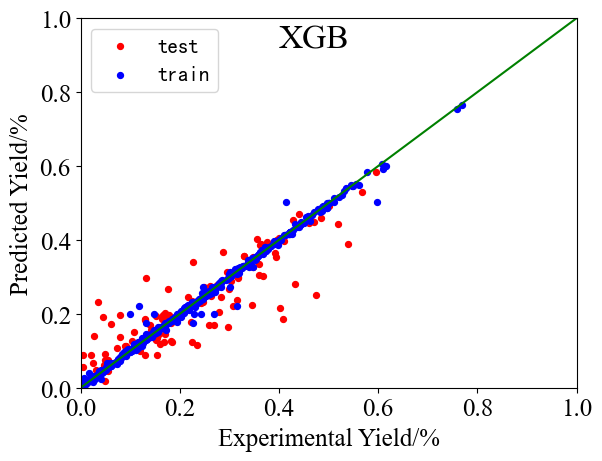

In [13]:
# 模型预测性能制图
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=18,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=18,label='train')
plt.xlim((0,1))
plt.xlabel('Experimental Yield/%',fontsize=18,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=18,fontname='Times New Roman')
plt.ylim((0,1))
plt.ylabel('Predicted Yield/%',fontsize=18,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=18,fontname='Times New Roman')
plt.plot([0,1],[0,1],color='g')
plt.text(0.4,0.92,'XGB',fontsize=24,font=Path('..\TimesNewRoman.ttf'))
plt.legend(fontsize=15)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


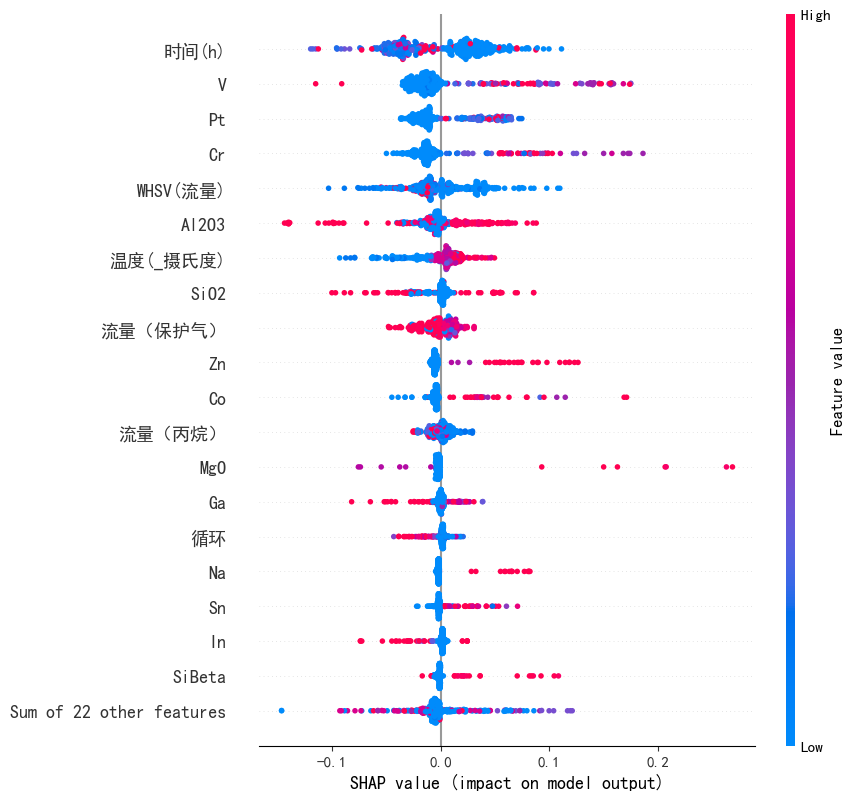

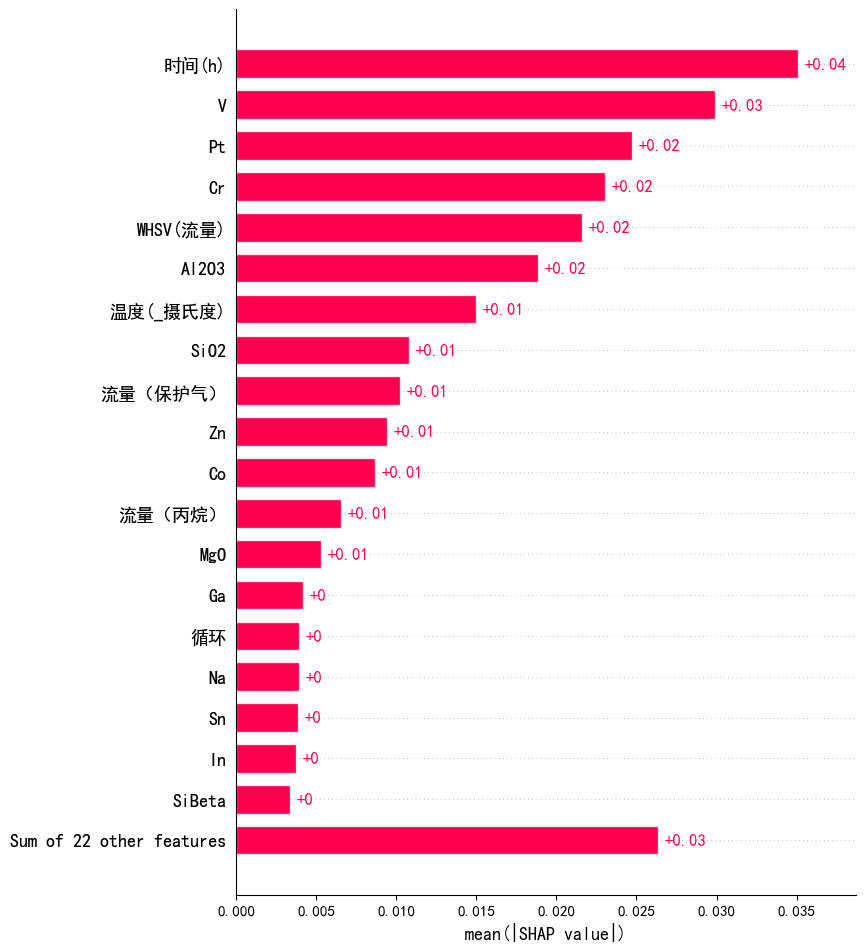

In [14]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)

In [15]:
# 排序特征重要性
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

Weight,Feature
0.3026 ± 0.1476,V
0.2494 ± 0.0610,时间(h)
0.2149 ± 0.0617,Cr
0.2059 ± 0.0512,Pt
0.1326 ± 0.0671,SiO2
0.1149 ± 0.0754,WHSV(流量)
0.1080 ± 0.0377,Al2O3
0.0932 ± 0.0579,MgO
0.0904 ± 0.0814,温度(_摄氏度)
0.0554 ± 0.0300,流量（保护气）
